## Step 1: Import Libraries & Config

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os, copy, random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

if torch.backends.mps.is_available():
    device = torch.device('mps'); print('Using Apple MPS (GPU) 🚀')
elif torch.cuda.is_available():
    device = torch.device('cuda'); print(f'Using CUDA: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu'); print('Using CPU')

if os.path.exists('/kaggle/input'):
    BASE_DIR = '/kaggle/input/cs-460-muffin-vs-chihuahua-classification-challenge'
else:
    BASE_DIR = './data'
TRAIN_DIR = f'{BASE_DIR}/train'
TEST_DIR  = f'{BASE_DIR}/kaggle_test_final'
print(f'TRAIN_DIR exists: {os.path.exists(TRAIN_DIR)}')
print(f'TEST_DIR  exists: {os.path.exists(TEST_DIR)}')

IMG_SIZE        = 320
BATCH_SIZE      = 12
PHASE1_EPOCHS   = 5
PHASE2_EPOCHS   = 30
PHASE1_LR       = 1e-3
PHASE2_LR       = 2e-4
VAL_SPLIT       = 0.15
PATIENCE        = 8
MIXUP_ALPHA     = 0.2
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY    = 1e-4
GRAD_CLIP       = 1.0
GRAD_ACCUM      = 2
NUM_WORKERS     = 0
print('Setup complete!')

Using Apple MPS (GPU) 🚀
TRAIN_DIR exists: True
TEST_DIR  exists: True
Setup complete!


## Step 2: Data Transforms + Mixup

In [2]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE + 40, IMG_SIZE + 40)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

_SZ = IMG_SIZE; _LG = int(IMG_SIZE * 1.15)
tta_transforms_list = [
    transforms.Compose([transforms.Resize((_SZ,_SZ)), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
    transforms.Compose([transforms.Resize((_SZ,_SZ)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
    transforms.Compose([transforms.Resize((_LG,_LG)), transforms.CenterCrop(_SZ), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
    transforms.Compose([transforms.Resize((_SZ,_SZ)), transforms.RandomRotation((15,15)), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
    transforms.Compose([transforms.Resize((_SZ,_SZ)), transforms.RandomRotation((-15,-15)), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
    transforms.Compose([transforms.Resize((_SZ,_SZ)), transforms.ColorJitter(brightness=0.2, contrast=0.2), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
    transforms.Compose([transforms.Resize((_SZ,_SZ)), transforms.RandomHorizontalFlip(p=1.0), transforms.RandomRotation((10,10)), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
    transforms.Compose([transforms.Resize((_LG,_LG)), transforms.CenterCrop(_SZ), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(MEAN,STD)]),
]

def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    idx = torch.randperm(x.size(0)).to(x.device)
    return lam * x + (1 - lam) * x[idx], y, y[idx], lam

print(f'Transforms ready! TTA passes: {len(tta_transforms_list)}')

Transforms ready! TTA passes: 8


## Step 3: Load Dataset & Stratified Split

In [3]:
class TransformSubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset, self.indices, self.transform = dataset, indices, transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform: img = self.transform(img)
        return img, label

full_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=None)
classes      = full_dataset.classes
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f'Classes: {classes} | class_to_idx: {class_to_idx} | Total: {len(full_dataset)}')

train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))), test_size=VAL_SPLIT,
    stratify=full_dataset.targets, random_state=SEED)

train_dataset = TransformSubset(full_dataset, train_idx, train_transforms)
val_dataset   = TransformSubset(full_dataset, val_idx,   val_transforms)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
print(f'Train: {len(train_dataset)} | Val: {len(val_dataset)}')

Classes: ['chihuahua', 'muffin'] | class_to_idx: {'chihuahua': 0, 'muffin': 1} | Total: 4733
Train: 4023 | Val: 710


## Step 4: Test Dataset

In [4]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir, self.transform = test_dir, transform
        self.image_files = sorted([f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        name = self.image_files[idx]
        img  = Image.open(os.path.join(self.test_dir, name)).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, name

print(f'Test images: {len(TestDataset(TEST_DIR))}')

Test images: 1138


## Step 5: Build Model — ConvNeXt-Base
ConvNeXt-Base (~89M params) ใช้แนวคิด Transformer ปรับปรุง CNN
มี Global Receptive Field กว้าง + แยกแยะ texture ละเอียดได้ดีเยี่ยม

In [5]:
model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1)

# Freeze backbone
for p in model.features.parameters():
    p.requires_grad = False

# Replace classifier head for 2 classes
in_ft = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_ft, 2)
model = model.to(device)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_p   = sum(p.numel() for p in model.parameters())
print(f'ConvNeXt-Base ready! Trainable: {trainable:,} / {total_p:,}')

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /Users/linkalphx/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:47<00:00, 7.40MB/s] 


ConvNeXt-Base ready! Trainable: 4,098 / 87,568,514


## Step 6: Training & Evaluation Functions

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, use_mixup=False, alpha=0.2, grad_accum=1):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(tqdm(loader, leave=False)):
        images, labels = images.to(device), labels.to(device)
        if use_mixup:
            mixed, y_a, y_b, lam = mixup_data(images, labels, alpha)
            out  = model(mixed)
            loss = lam * criterion(out, y_a) + (1 - lam) * criterion(out, y_b)
        else:
            out  = model(images)
            loss = criterion(out, labels)
        (loss / grad_accum).backward()
        if (i + 1) % grad_accum == 0 or (i + 1) == len(loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step(); optimizer.zero_grad()
        loss_sum += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return loss_sum / len(loader), 100.0 * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        out = model(images); loss = criterion(out, labels)
        loss_sum += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return loss_sum / len(loader), 100.0 * correct / total

print('Training functions ready!')

Training functions ready!


## Step 7: Phase 1 — Train Head Only (LR=1e-3)

In [7]:
criterion    = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
best_val_acc = 0.0
best_weights = copy.deepcopy(model.state_dict())

opt1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=PHASE1_LR, weight_decay=WEIGHT_DECAY)
sch1 = optim.lr_scheduler.CosineAnnealingLR(opt1, T_max=PHASE1_EPOCHS, eta_min=1e-6)

print('===== Phase 1: Head Only =====')
for ep in range(1, PHASE1_EPOCHS + 1):
    tl, ta = train_one_epoch(model, train_loader, criterion, opt1, use_mixup=False, grad_accum=1)
    vl, va = evaluate(model, val_loader, criterion)
    sch1.step()
    flag = ' ★ BEST' if va > best_val_acc else ''
    print(f'Epoch [{ep:02d}/{PHASE1_EPOCHS}] Train Loss: {tl:.4f} Acc: {ta:.2f}% | Val Loss: {vl:.4f} Acc: {va:.2f}%{flag}')
    if va > best_val_acc:
        best_val_acc = va; best_weights = copy.deepcopy(model.state_dict())
        torch.save(best_weights, 'best_model.pth')
print(f'\nBest Val Accuracy (Phase 1): {best_val_acc:.2f}%')

===== Phase 1: Head Only =====


Epoch [01/5] Train Loss: 0.2452 Acc: 98.51% | Val Loss: 0.2225 Acc: 99.58% ★ BEST


Epoch [02/5] Train Loss: 0.2281 Acc: 99.43% | Val Loss: 0.2217 Acc: 99.30%


Epoch [03/5] Train Loss: 0.2227 Acc: 99.50% | Val Loss: 0.2201 Acc: 99.58%


Epoch [04/5] Train Loss: 0.2203 Acc: 99.68% | Val Loss: 0.2186 Acc: 99.44%


Epoch [05/5] Train Loss: 0.2199 Acc: 99.68% | Val Loss: 0.2188 Acc: 99.58%

Best Val Accuracy (Phase 1): 99.58%


## Step 8: Phase 2 — Full Fine-tune with Mixup (LR=2e-4)

In [8]:
model.load_state_dict(best_weights)
for p in model.parameters(): p.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Phase 2 Trainable params: {trainable:,}')

opt2 = optim.AdamW(model.parameters(), lr=PHASE2_LR, weight_decay=WEIGHT_DECAY)
sch2 = optim.lr_scheduler.CosineAnnealingLR(opt2, T_max=PHASE2_EPOCHS, eta_min=1e-6)
no_improve = 0

print('\n===== Phase 2: Full Fine-tune + Mixup =====')
for ep in range(1, PHASE2_EPOCHS + 1):
    tl, ta = train_one_epoch(model, train_loader, criterion, opt2,
                             use_mixup=True, alpha=MIXUP_ALPHA, grad_accum=GRAD_ACCUM)
    vl, va = evaluate(model, val_loader, criterion)
    sch2.step()
    flag = ' ★ BEST' if va > best_val_acc else ''
    print(f'Epoch [{ep:02d}/{PHASE2_EPOCHS}] Train Loss: {tl:.4f} Acc: {ta:.2f}% | Val Loss: {vl:.4f} Acc: {va:.2f}%{flag}')
    if va > best_val_acc:
        best_val_acc = va; best_weights = copy.deepcopy(model.state_dict())
        torch.save(best_weights, 'best_model.pth'); no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'Early stopping at epoch {ep}'); break

model.load_state_dict(best_weights)
print(f'\nFinal Best Val Accuracy: {best_val_acc:.2f}%')

Phase 2 Trainable params: 87,568,514

===== Phase 2: Full Fine-tune + Mixup =====


Epoch [01/30] Train Loss: 0.3022 Acc: 75.62% | Val Loss: 0.2032 Acc: 99.72% ★ BEST


Epoch [02/30] Train Loss: 0.2981 Acc: 75.66% | Val Loss: 0.2139 Acc: 99.86% ★ BEST


Epoch [03/30] Train Loss: 0.2996 Acc: 77.11% | Val Loss: 0.2041 Acc: 99.86%


Epoch [04/30] Train Loss: 0.2887 Acc: 77.78% | Val Loss: 0.2034 Acc: 100.00% ★ BEST


Epoch [05/30] Train Loss: 0.2930 Acc: 79.27% | Val Loss: 0.2049 Acc: 99.58%


Epoch [06/30] Train Loss: 0.2823 Acc: 79.12% | Val Loss: 0.2062 Acc: 99.72%


Epoch [07/30] Train Loss: 0.2910 Acc: 75.71% | Val Loss: 0.2027 Acc: 99.72%


Epoch [08/30] Train Loss: 0.2834 Acc: 76.31% | Val Loss: 0.2005 Acc: 99.86%


Epoch [09/30] Train Loss: 0.2776 Acc: 77.13% | Val Loss: 0.2073 Acc: 99.86%


Epoch [10/30] Train Loss: 0.2772 Acc: 78.70% | Val Loss: 0.2035 Acc: 99.72%


Epoch [11/30] Train Loss: 0.2802 Acc: 76.01% | Val Loss: 0.2048 Acc: 99.72%


Epoch [12/30] Train Loss: 0.2697 Acc: 77.93% | Val Loss: 0.2066 Acc: 99.72%
Early stopping at epoch 12

Final Best Val Accuracy: 100.00%


## Step 9: TTA Inference on Test Set (8 passes)

In [9]:
print('Starting TTA Inference...')
model.eval()
softmax = nn.Softmax(dim=1)
all_probs, all_filenames = None, None

for t_idx, tta_tf in enumerate(tta_transforms_list):
    print(f'  TTA pass {t_idx+1}/{len(tta_transforms_list)}...')
    td = TestDataset(TEST_DIR, transform=tta_tf)
    tl = DataLoader(td, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    pass_probs, pass_files = [], []
    with torch.no_grad():
        for imgs, fnames in tqdm(tl, desc=f'TTA {t_idx+1}', leave=False):
            p = softmax(model(imgs.to(device))).cpu().numpy()
            pass_probs.append(p)
            if t_idx == 0: pass_files.extend(fnames)
    pass_probs = np.concatenate(pass_probs, axis=0)
    if all_probs is None:
        all_probs, all_filenames = pass_probs, pass_files
    else:
        all_probs += pass_probs

all_probs   /= len(tta_transforms_list)
pred_indices = np.argmax(all_probs, axis=1)
predictions  = [idx_to_class[i] for i in pred_indices]
print(f'Done! Total predictions: {len(predictions)}')

Starting TTA Inference...
  TTA pass 1/8...


  TTA pass 2/8...


  TTA pass 3/8...


  TTA pass 4/8...


  TTA pass 5/8...


  TTA pass 6/8...


  TTA pass 7/8...


  TTA pass 8/8...


Done! Total predictions: 1138


## Step 10: Save submission.csv

In [10]:
submission_df = pd.DataFrame({'ID': all_filenames, 'Predict': predictions})
submission_df.to_csv('submission.csv', index=False)
print('submission.csv saved!')
print(submission_df.head(10))
print(f'\nPrediction distribution:')
print(submission_df['Predict'].value_counts())

submission.csv saved!
               ID    Predict
0     img_0_0.jpg     muffin
1    img_0_10.jpg     muffin
2  img_0_1000.jpg     muffin
3  img_0_1037.jpg     muffin
4   img_0_105.jpg     muffin
5  img_0_1050.jpg     muffin
6  img_0_1051.jpg     muffin
7  img_0_1061.jpg     muffin
8  img_0_1063.jpg     muffin
9  img_0_1071.jpg  chihuahua

Prediction distribution:
Predict
chihuahua    642
muffin       496
Name: count, dtype: int64


## Step 11: Confusion Matrix & Classification Report

--- Classification Report (Validation Set) ---
              precision    recall  f1-score   support

   chihuahua       1.00      1.00      1.00       384
      muffin       1.00      1.00      1.00       326

    accuracy                           1.00       710
   macro avg       1.00      1.00      1.00       710
weighted avg       1.00      1.00      1.00       710



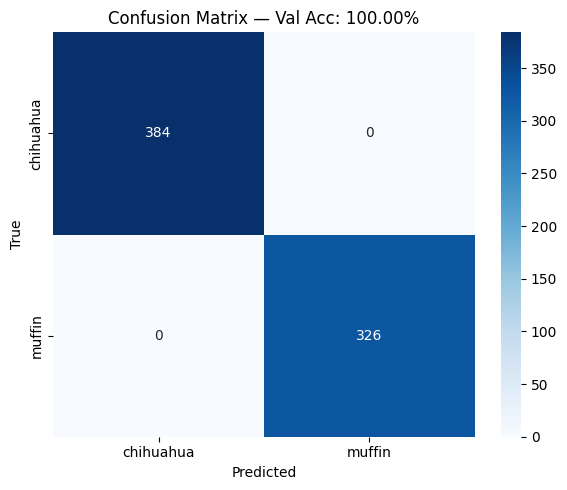

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred_all = [], []
with torch.no_grad():
    for images, labels in val_loader:
        outputs  = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

print('--- Classification Report (Validation Set) ---')
print(classification_report(y_true, y_pred_all, target_names=classes))

cm = confusion_matrix(y_true, y_pred_all)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix — Val Acc: {best_val_acc:.2f}%')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()